In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('transformation').getOrCreate()

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 21:28:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/23 21:29:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
OOSR = spark.read.csv('OOSR/OOSR.csv', inferSchema=True, header=True)

In [3]:
categorical_features = ['Age_group', 'Gender', 'Region']
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep") 
            for col in categorical_features]

# OneHotEncoder for indexed categorical features
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in categorical_features]

# Assemble features vector
assembler_inputs = [col + "_encoded" for col in categorical_features]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")


In [4]:
lr = LogisticRegression(featuresCol="features", labelCol="High_OOSR")
pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

In [5]:
model = pipeline.fit(OOSR)

In [6]:
# Extracting the stages
indexer_stages = model.stages[:len(indexers)]
encoder_stages = model.stages[len(indexers):-2]
assembler_stage = model.stages[-2]
lr_model = model.stages[-1]

# Manually generate encoded feature names
encoded_feature_names = []
for col in categorical_features:
    indexer = next(stage for stage in indexer_stages if stage.getOutputCol() == col + "_index")
    categories = indexer.labels
    encoded_feature_names.extend([f"{col}_{category}" for category in categories])

# Extract coefficients and intercept
coefficients = lr_model.coefficients.toArray()
intercept = lr_model.intercept

# Construct the model expression
expression = f"P(High_OOSR=1|X) = 1 / (1 + e^(-({intercept} + "

# Build the logistic regression expression
for i, coef in enumerate(coefficients):
    if i != 0:
        expression += " + "
    feature_name = encoded_feature_names[i]
    expression += f"({np.round(coef, 4)} * {feature_name})"
expression += ")))"

print(expression)


P(High_OOSR=1|X) = 1 / (1 + e^(-(-3.721232125320918 + (-1.0991 * Age_group_Lower_Secondary) + (1.5449 * Age_group_Preprimary) + (-1.677 * Age_group_Primary) + (1.2313 * Age_group_Upper_Secondary) + (0.0214 * Gender_Female) + (-0.0214 * Gender_Male) + (1.8989 * Region_Africa) + (0.1494 * Region_Asia) + (-1.0888 * Region_Europe) + (-1.3815 * Region_Americas) + (0.0824 * Region_Oceania))))


In [7]:
categorical_features = ['Age_group', 'Gender', 'Region']
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep") 
            for col in categorical_features]

# OneHotEncoder for indexed categorical features
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in categorical_features]

# Assemble features vector
assembler_inputs = [col + "_encoded" for col in categorical_features]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

lr = LogisticRegression(featuresCol="features", labelCol="High_OOSR")
pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

# Divide the data set into a training set and a test set
train_data, test_data = OOSR.randomSplit([0.7, 0.3], seed=722)

model = pipeline.fit(train_data)

# Extracting the stages
indexer_stages = model.stages[:len(indexers)]
encoder_stages = model.stages[len(indexers):-2]
assembler_stage = model.stages[-2]
lr_model = model.stages[-1]

# Manually generate encoded feature names
encoded_feature_names = []
for col in categorical_features:
    indexer = next(stage for stage in indexer_stages if stage.getOutputCol() == col + "_index")
    categories = indexer.labels
    encoded_feature_names.extend([f"{col}_{category}" for category in categories])

# Extract coefficients and intercept
coefficients = lr_model.coefficients.toArray()
intercept = lr_model.intercept

# Construct the model expression
expression = f"P(High_OOSR=1|X) = 1 / (1 + e^(-({intercept} + "

# Build the logistic regression expression
for i, coef in enumerate(coefficients):
    if i != 0:
        expression += " + "
    feature_name = encoded_feature_names[i]
    expression += f"({np.round(coef, 4)} * {feature_name})"
expression += ")))"

print(expression)

P(High_OOSR=1|X) = 1 / (1 + e^(-(-3.792626913352898 + (1.6777 * Age_group_Preprimary) + (-1.1874 * Age_group_Lower_Secondary) + (-1.9367 * Age_group_Primary) + (1.4395 * Age_group_Upper_Secondary) + (-0.1785 * Gender_Male) + (0.1785 * Gender_Female) + (1.8401 * Region_Africa) + (0.3656 * Region_Asia) + (-1.5385 * Region_Europe) + (-1.0749 * Region_Americas) + (0.1008 * Region_Oceania))))


In [12]:
# Model evaluation
evaluator = BinaryClassificationEvaluator(labelCol="High_OOSR", rawPredictionCol="rawPrediction",
                                          metricName="areaUnderROC")

predictions = model.transform(test_data)
accuracy = evaluator.evaluate(predictions)
print("The accuracy of the logistic regression model on the test set is {:.2f}%.".format(accuracy * 100))

The accuracy of the logistic regression model on the test set is 82.70%.


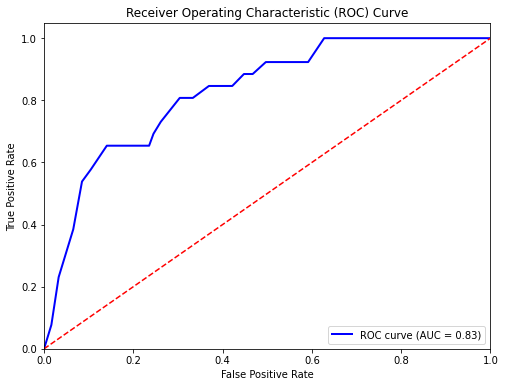

In [13]:
y_prob = predictions.select("probability").collect()
y_prob = [prob[0][1] for prob in y_prob]

y_test = test_data.select("High_OOSR").collect()
y_test = [label[0] for label in y_test]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The accuracy of the logistic regression model on the test set is 83.35%.


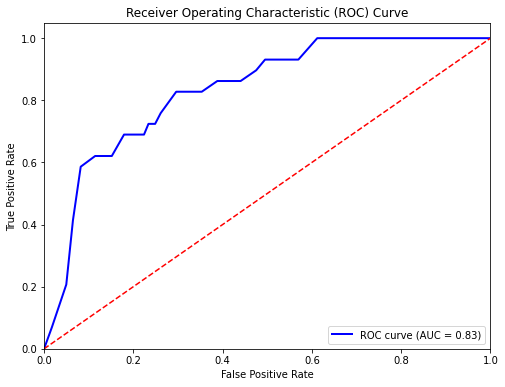

In [14]:
categorical_features = ['Age_group', 'Gender', 'Region']
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep") 
            for col in categorical_features]

# OneHotEncoder for indexed categorical features
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in categorical_features]

# Assemble features vector
assembler_inputs = [col + "_encoded" for col in categorical_features]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

lr = LogisticRegression(featuresCol="features", labelCol="High_OOSR")
pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

# Divide the data set into a training set and a test set
train_data, test_data = OOSR.randomSplit([0.75, 0.25], seed=722)

model = pipeline.fit(train_data)

# Model evaluation
evaluator = BinaryClassificationEvaluator(labelCol="High_OOSR", rawPredictionCol="rawPrediction",
                                          metricName="areaUnderROC")

predictions = model.transform(test_data)
accuracy = evaluator.evaluate(predictions)
print("The accuracy of the logistic regression model on the test set is {:.2f}%.".format(accuracy * 100))

y_prob = predictions.select("probability").collect()
y_prob = [prob[0][1] for prob in y_prob]

y_test = test_data.select("High_OOSR").collect()
y_test = [label[0] for label in y_test]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The accuracy of the logistic regression model on the test set is 82.70%.


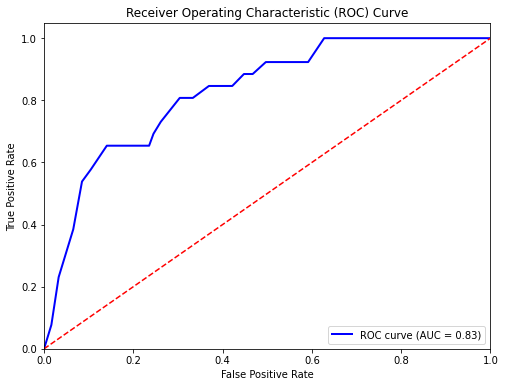

In [15]:
categorical_features = ['Age_group', 'Gender', 'Region']
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep") 
            for col in categorical_features]

# OneHotEncoder for indexed categorical features
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in categorical_features]

# Assemble features vector
assembler_inputs = [col + "_encoded" for col in categorical_features]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

lr = LogisticRegression(featuresCol="features", labelCol="High_OOSR")
pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

# Divide the data set into a training set and a test set
train_data, test_data = OOSR.randomSplit([0.8, 0.2], seed=722)

model = pipeline.fit(train_data)

# Model evaluation
evaluator = BinaryClassificationEvaluator(labelCol="High_OOSR", rawPredictionCol="rawPrediction",
                                          metricName="areaUnderROC")

predictions = model.transform(test_data)
accuracy = evaluator.evaluate(predictions)
print("The accuracy of the logistic regression model on the test set is {:.2f}%.".format(accuracy * 100))

y_prob = predictions.select("probability").collect()
y_prob = [prob[0][1] for prob in y_prob]

y_test = test_data.select("High_OOSR").collect()
y_test = [label[0] for label in y_test]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()